<a href="https://colab.research.google.com/github/pedrorotta/procesamiento_de_imagenes/blob/main/Detecci%C3%B3n_de_objetos_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#configuración
#Conectar google drive: google.colab import drive /content/drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Curso procesamiento'
os.chdir(root)
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from PIL import Image

Mounted at /content/drive


In [ ]:
def showrgb(image = None, title = 'Image', size = 4 ):
  #Creada para poder visualizar la imágen rgb. 
  w,h = image.shape[1],image.shape[0]
  aspect_ratio = w/h
  plt.figure(figsize = (size*aspect_ratio,size))
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

#**Detección de objetos I.**

En este capítulo exploraremos los siguientes objetivos:


## Objetivos:

*  Transformada de Fourier
*  Filtros en el dominio de la frecuencia
*  Contornos 
*  Momentos
*  Blob detection

## Transformada de Fourier

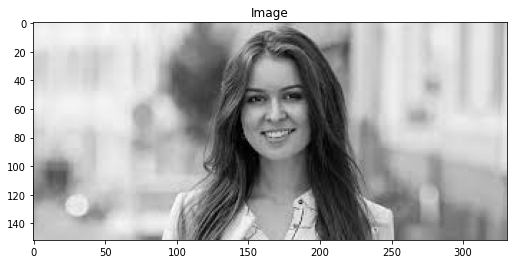

In [ ]:
mujer = cv2.imread('images/img1.jpg')
mujerg = cv2.cvtColor(mujer,cv2.COLOR_RGB2GRAY)
showrgb(mujerg)

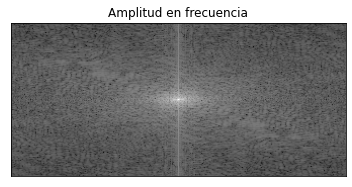

In [ ]:
dft_mujer = cv2.dft(np.float32(mujerg),flags = cv2.DFT_COMPLEX_OUTPUT)
#Definir la frecuencia central como zero. 
dft_mujer_shift = np.fft.fftshift(dft_mujer)
# Obtener el mapa de amplitudes
amplitud_dft_mujer = 20*np.log(cv2.magnitude(dft_mujer_shift[:,:,0],dft_mujer_shift[:,:,1]))


plt.imshow(amplitud_dft_mujer,cmap = 'gray')
plt.title('Amplitud en frecuencia'), plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
#Usemos una máscara 30x30 y filtro pasa alto

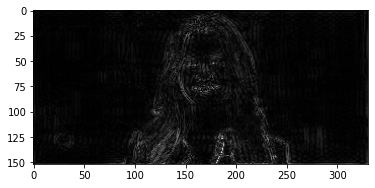

In [ ]:
rows, cols = mujerg.shape
crow,ccol= int(rows/2),int(cols/2)

#Crear la máscara 30x30
#amplitud_ft_mujer_copy = amplitud_dft_mujer.copy()
#amplitud_ft_mujer_copy[crow-30:crow+30,ccol-30:ccol+30] = 0
mask = np.ones((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 0
#plt.imshow(amplitud_ft_mujer_copy,cmap='gray')

#Aplicarlo a la transformada de fourier

dtf_shift_trans = dft_mujer_shift*mask
dtf_i_shift_mujer = np.fft.ifftshift(dtf_shift_trans)
dtf_i_mujer = cv2.idft(dtf_i_shift_mujer)
dtf_i_mujer_img = cv2.magnitude(dtf_i_mujer[:,:,0],dtf_i_mujer[:,:,1])

plt.imshow(dtf_i_mujer_img, cmap = 'gray')
plt.show()

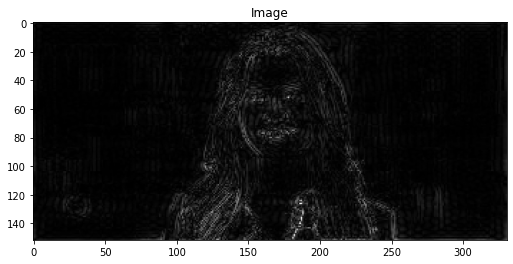

In [ ]:
#Normalizar la imagen 
dtf_i_mujer_norm = np.uint8((dtf_i_mujer_img-np.min(dtf_i_mujer_img))*255/(np.max(dtf_i_mujer_img)-np.min(dtf_i_mujer_img)))
showrgb(dtf_i_mujer_norm)

## **Contornos y Herarquía**

Para detectar objetos con ayuda de la detección de bordes, debemos realizar un procesamiento de contornos. 



### **¿Qué son los contornos??** 

La obtención de la posición de los bordes en una imagen se llama contornear. 

Este paso es importante para poder realizar la detección de objetos. 

## CUADRADO

In [ ]:
!wget https://files.liveworksheets.com/def_files/2020/4/9/4091112501854/4091112501854001.jpg
cuadrados = cv2.imread('4091112501854001.jpg')
cv2.imwrite('images/cuadros.jpg',cuadrados)

--2022-11-02 05:52:41--  https://files.liveworksheets.com/def_files/2020/4/9/4091112501854/4091112501854001.jpg
Resolving files.liveworksheets.com (files.liveworksheets.com)... 104.26.7.3, 104.26.6.3, 172.67.73.76, ...
Connecting to files.liveworksheets.com (files.liveworksheets.com)|104.26.7.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35768 (35K) [image/jpeg]
Saving to: ‘4091112501854001.jpg.1’

4091112501854001.jp 100%[===================>]  34.93K  --.-KB/s    in 0.007s  

2022-11-02 05:52:41 (4.69 MB/s) - ‘4091112501854001.jpg.1’ saved [35768/35768]



True

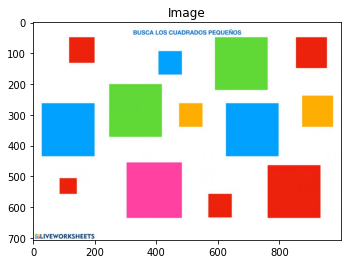

In [ ]:
showrgb(cuadrados)

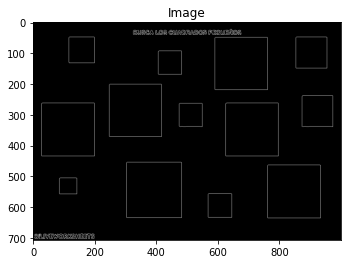

In [ ]:
cuadros_g = cv2.cvtColor(cuadrados,cv2.COLOR_BGR2GRAY)
_,cuadros_t = cv2.threshold(cuadros_g,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cuadros_canny = cv2.Canny(cuadros_t,np.mean(cuadros_t),np.mean(cuadros_t)*1.20)
showrgb(cuadros_canny)


## ROJO

In [ ]:
!wget https://e.rpp-noticias.io/normal/2016/04/19/001600_122364.jpg

In [ ]:
rojo = cv2.imread('images/rojo.jpg')

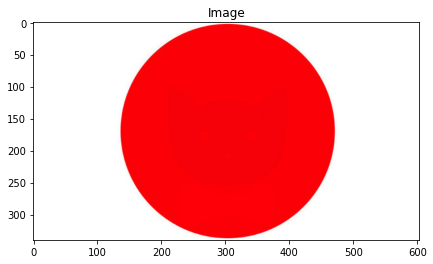

In [ ]:
showrgb(rojo)

In [ ]:
rojo_t = cv2.cvtColor(rojo,cv2.COLOR_BGR2GRAY)



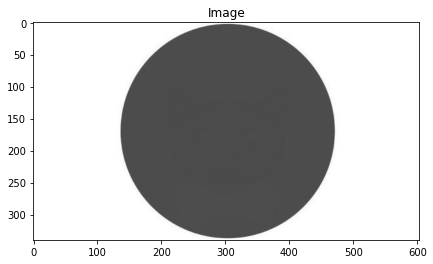

In [ ]:
showrgb(rojo_t)

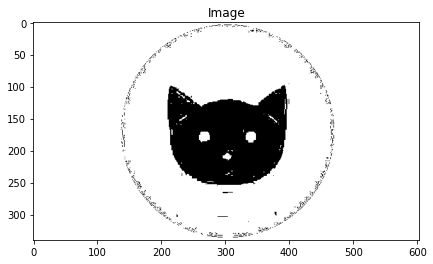

In [ ]:
#Binarización
_,rojo_1 = cv2.threshold(rojo_t,75,255,cv2.THRESH_BINARY)
showrgb(rojo_1)

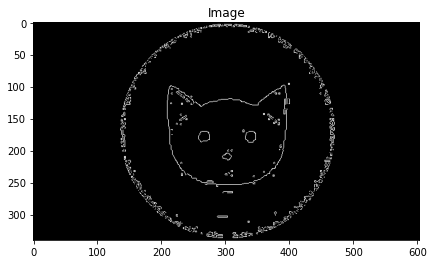

In [ ]:
rojo_canny = cv2.Canny(rojo_1,np.mean(rojo_1),np.mean(rojo_1)*1.20)
showrgb(rojo_canny)

### **La función de cv2.countours() devuelve una tupla con los contornos y la jerarquía**

Tiene 3 argumentos: La Img,El modo de jerarquía y el método de contorneo. 

**EL TERCER ARGUMENTO DE LA FUNCIÓN ES EL MÉTODO DE APROXIMACIÓN DE CONTORNO**

Existen 2 Tipos: 

*   cv2.CHAIN_APPROX_NONE => Devuelve todos los puntos de los bordes. 

*   cv2.CHAIN_APPROX_SIMPLE => Borra todos los puntos redundates. 


**EL SEGUNDO ARGUMENTO DE LA FUNCIÓN ES EL MODO DE RECUPERACIÓN DE CONTORNO**

Este modo determina qué tipo de jerarquía decides tener en la imagen: 

*   cv2.RETR_LIST : No existe jerarquía de bordes
*   cv2.RETR_EXTERNAL: Solo recoje los de mayor jeraquía. 

*   RETR_CCOMP : Devuelve 2 niveles de jerarquía una jerarquía externa o superior y otra interna o inferior. 

*   RETR_TREE : Devuelve una lista completa de jerarquías. 

**LA FUNCIÓN DE cv2.drawContours() DEVUELVE UNA IMAGEN CON LOS  CONTORNOS DIBUJADOS**

Tiene 5 argumentos: La Img donde se dibujará los contornos, La lista de contornos, la Jerarquía y el grosor de los contornos

**EL TERCER ARGUMENTO DE LA FUNCIÓN LA JERARQUÍA DE CONTORNOS**

* -1 : Todos los contornos
* 0 : Contorno padre
* 1 : Contorno hijo
* ...

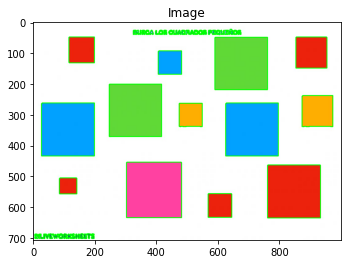

146


In [ ]:
cuadro1 = cuadrados.copy()
contours, hierarchy = cv2.findContours(cuadros_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(cuadro1,contours,-1,(0,255,0),2)
showrgb(cuadro1)
print(len(contours))

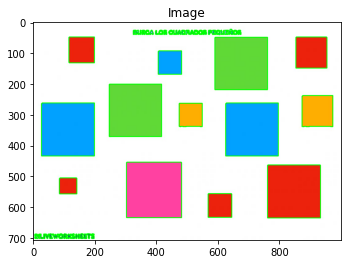

146


In [ ]:
del contours, hierarchy
cuadro2 = cuadrados.copy()
contours, hierarchy = cv2.findContours(cuadros_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(cuadro2,contours,-1,(0,255,0),2)
showrgb(cuadro2)
print(len(contours))

In [ ]:
del contours, hierarchy,cuadro3
cuadro3 = cuadrados.copy()
contours, hierarchy = cv2.findContours(cuadros_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(hierarchy)
#cv2.drawContours(cuadro3,contours,1,(0,255,0),300)
#showrgb(cuadro3)
#print(len(contours))

[[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  [  4   2  -1  -1]
  [  5   3  -1  -1]
  [  6   4  -1  -1]
  [  7   5  -1  -1]
  [  8   6  -1  -1]
  [  9   7  -1  -1]
  [ 10   8  -1  -1]
  [ 11   9  -1  -1]
  [ 12  10  -1  -1]
  [ 13  11  -1  -1]
  [ 14  12  -1  -1]
  [ 15  13  -1  -1]
  [ 16  14  -1  -1]
  [ 17  15  -1  -1]
  [ 18  16  -1  -1]
  [ 19  17  -1  -1]
  [ 20  18  -1  -1]
  [ 21  19  -1  -1]
  [ 22  20  -1  -1]
  [ 23  21  -1  -1]
  [ 24  22  -1  -1]
  [ 25  23  -1  -1]
  [ 26  24  -1  -1]
  [ 27  25  -1  -1]
  [ 28  26  -1  -1]
  [ 29  27  -1  -1]
  [ 30  28  -1  -1]
  [ 31  29  -1  -1]
  [ 32  30  -1  -1]
  [ 33  31  -1  -1]
  [ 34  32  -1  -1]
  [ 35  33  -1  -1]
  [ 36  34  -1  -1]
  [ 37  35  -1  -1]
  [ 38  36  -1  -1]
  [ 39  37  -1  -1]
  [ 40  38  -1  -1]
  [ 41  39  -1  -1]
  [ 42  40  -1  -1]
  [ 43  41  -1  -1]
  [ 44  42  -1  -1]
  [ 45  43  -1  -1]
  [ 46  44  -1  -1]
  [ 47  45  -1  -1]
  [ 48  46  -1  -1]
  [ 49  47  -1  -1]
  [ 50  48  -1  -1]


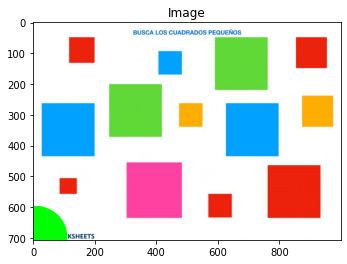

9


In [ ]:
del contours, hierarchy,cuadro3
cuadro3 = cuadrados.copy()
contours, hierarchy = cv2.findContours(cuadros_canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#print(hierarchy)
cv2.drawContours(cuadro3,contours,3,(0,255,0),200)
showrgb(cuadro3)
print(len(contours[3]))

In [ ]:
del contours, hierarchy,cuadro3
cuadro3 = cuadrados.copy()
contours, hierarchy = cv2.findContours(cuadros_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(hierarchy)
#cv2.drawContours(cuadro3,contours,-2,(0,255,0),3)
#showrgb(cuadro3)
#print(len(contours))

[[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  [  4   2  -1  -1]
  [  5   3  -1  -1]
  [  6   4  -1  -1]
  [  7   5  -1  -1]
  [  8   6  -1  -1]
  [  9   7  -1  -1]
  [ 10   8  -1  -1]
  [ 11   9  -1  -1]
  [ 12  10  -1  -1]
  [ 13  11  -1  -1]
  [ 15  12  14  -1]
  [ -1  -1  -1  13]
  [ 16  13  -1  -1]
  [ 17  15  -1  -1]
  [ 19  16  18  -1]
  [ -1  -1  -1  17]
  [ 20  17  -1  -1]
  [ 21  19  -1  -1]
  [ 22  20  -1  -1]
  [ 23  21  -1  -1]
  [ 24  22  -1  -1]
  [ 25  23  -1  -1]
  [ 26  24  -1  -1]
  [ 27  25  -1  -1]
  [ 30  26  28  -1]
  [ 29  -1  -1  27]
  [ -1  28  -1  27]
  [ 31  27  -1  -1]
  [ 33  30  32  -1]
  [ -1  -1  -1  31]
  [ 34  31  -1  -1]
  [ 35  33  -1  -1]
  [ 36  34  -1  -1]
  [ 37  35  -1  -1]
  [ 38  36  -1  -1]
  [ 40  37  39  -1]
  [ -1  -1  -1  38]
  [ 42  38  41  -1]
  [ -1  -1  -1  40]
  [ 44  40  43  -1]
  [ -1  -1  -1  42]
  [ 46  42  45  -1]
  [ -1  -1  -1  44]
  [ 48  44  47  -1]
  [ -1  -1  -1  46]
  [ 50  46  49  -1]
  [ -1  -1  -1  48]


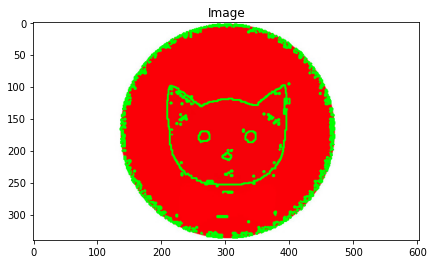

501


In [ ]:
rojo1 = rojo.copy() 
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(rojo1,contours,-1,(0,255,0),2)
showrgb(rojo1)
print(len(contours))

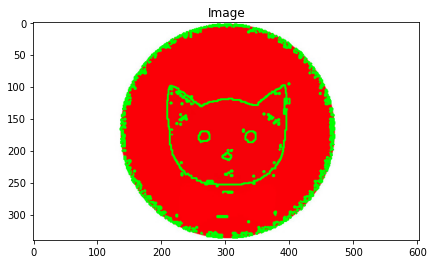

501


In [ ]:
del contours, hierarchy
rojo2 = rojo.copy() 
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(rojo2,contours,-1,(0,255,0),2)
showrgb(rojo2)
print(len(contours))

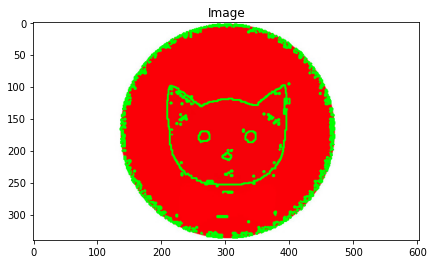

[[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  ...
  [499 497  -1 495]
  [500 498  -1 495]
  [ -1 499  -1 495]]]


In [ ]:
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
rojo_contours.append(cv2.drawContours(rojos[6],contours,0,(0,255,0),2))
showrgb(rojo_contours[1])
print(hierarchy)

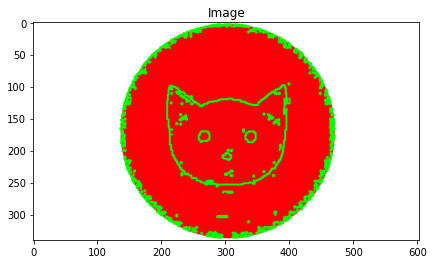

In [ ]:
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rojo_contours.append(cv2.drawContours(rojos[4],contours,2,(0,255,0),2))
showrgb(rojo_contours[4])

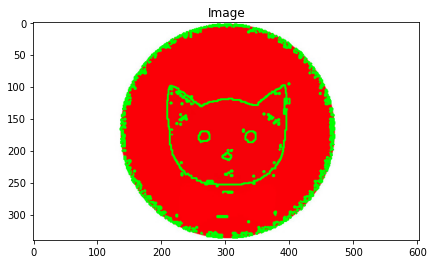

In [ ]:
showrgb(rojo_contours[1])

In [ ]:
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
rojo_contours.append(cv2.drawContours(rojos[5],contours,-1,(0,255,0),4))
showrgb(rojo_contours[5])
print(hierarchy)

IndexError: ignored

In [ ]:
contours, hierarchy = cv2.findContours(rojo_canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
rojo_contours.append(cv2.drawContours(rojos[5],contours,-1,(0,255,0),4))
showrgb(rojo_contours[5])